In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
import sklearn.metrics as sm
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve

from statsmodels.tsa.stattools import adfuller
from scipy import stats

### Load the dataset

In [12]:
raw_df = pd.read_csv('google-stock-dataset.csv')
raw_df = raw_df.drop(['Unnamed: 0','Adj Close'], axis=1)
raw_df['Date']=pd.to_datetime(raw_df['Date'])
raw_df.set_index("Date", inplace=True)
raw_df


,Price,High,Low,Close,Volume
Date,,,,,
2013-04-15,19.67,19.94,19.44,19.57,98025876
2013-04-16,19.68,19.92,19.62,19.85,69610320
2013-04-17,19.69,19.79,19.47,19.58,81398520
2013-04-18,19.65,19.66,19.05,19.17,132767100
2013-04-19,19.25,20.11,19.18,20.02,231895872
...,...,...,...,...,...
2023-03-27,104.62,104.76,101.93,102.46,31120900
2023-03-28,102.44,102.45,99.74,101.03,32057900
2023-03-29,102.28,102.49,100.65,101.39,28779600


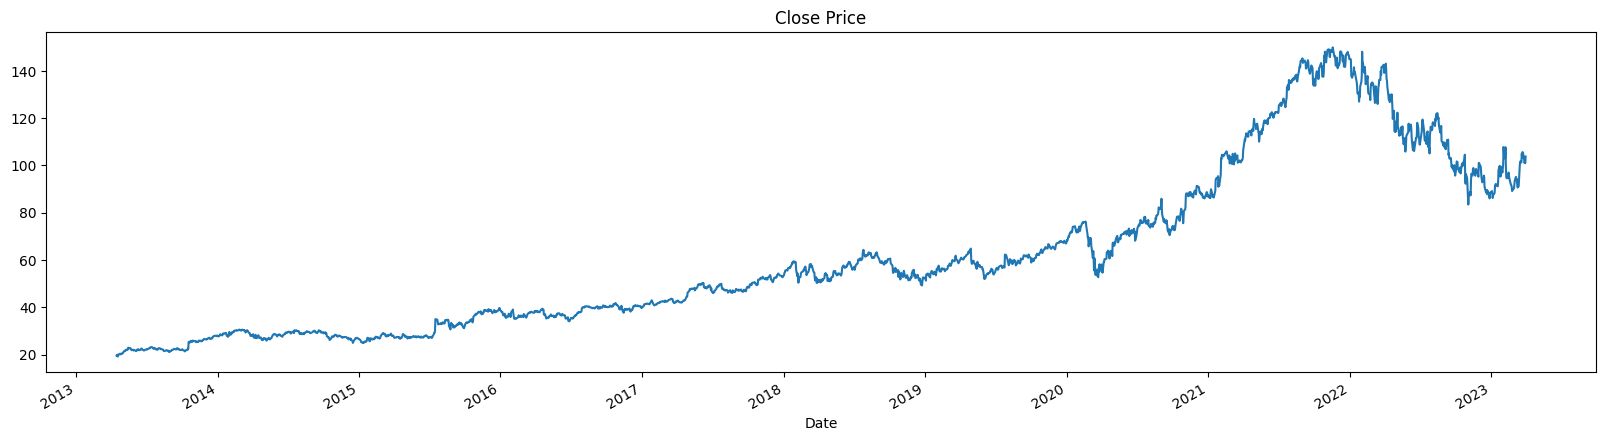

In [13]:
raw_df.Close.plot(figsize=(20,5), title="Close Price")
plt.show()

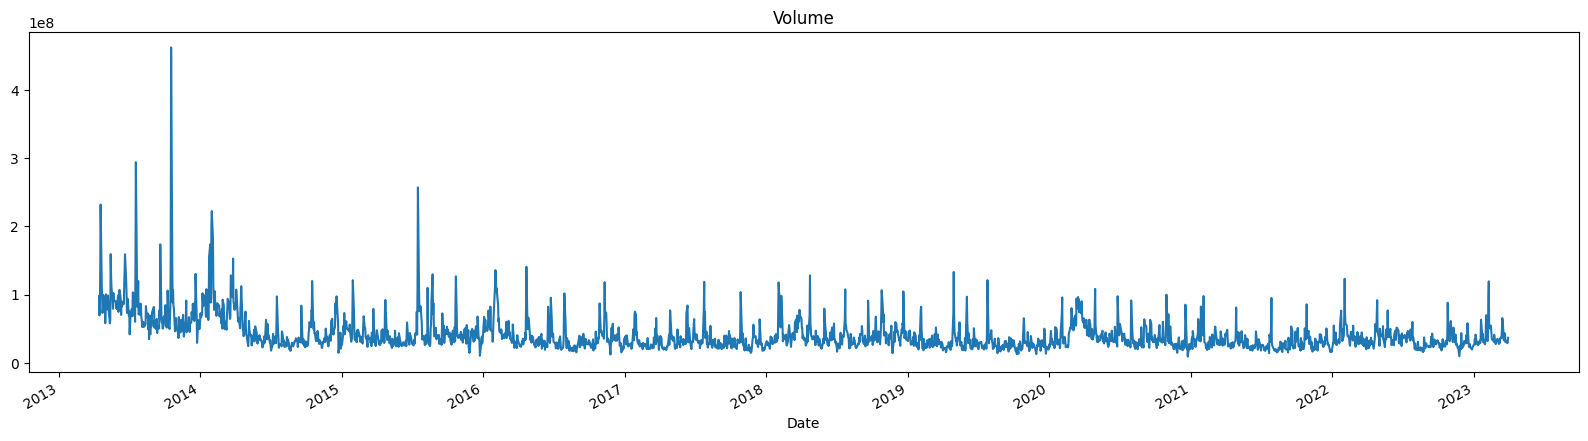

In [14]:
raw_df.Volume.plot(figsize=(20,5), title="Volume")
plt.show()

### Heatmap

<Axes: >

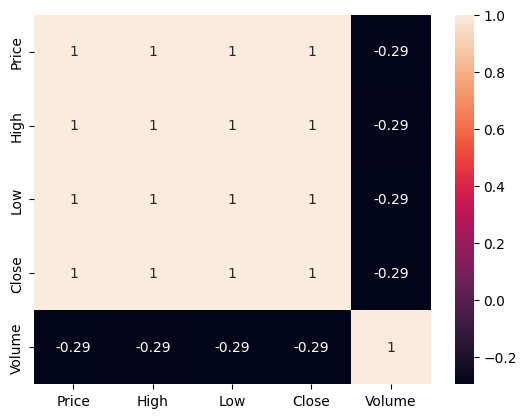

In [15]:
sns.heatmap(raw_df.corr(),robust=True, annot=True)

In [16]:
raw_df = raw_df.drop(['Volume'], axis=1)
raw_df

,Price,High,Low,Close
Date,,,,
2013-04-15,19.67,19.94,19.44,19.57
2013-04-16,19.68,19.92,19.62,19.85
2013-04-17,19.69,19.79,19.47,19.58
2013-04-18,19.65,19.66,19.05,19.17
2013-04-19,19.25,20.11,19.18,20.02
...,...,...,...,...
2023-03-27,104.62,104.76,101.93,102.46
2023-03-28,102.44,102.45,99.74,101.03
2023-03-29,102.28,102.49,100.65,101.39


In [17]:
#Add time-step feature
df_copy=raw_df.copy()
raw_df['Time']=np.arange(len(raw_df.index))
raw_df

,Price,High,Low,Close,Time
Date,,,,,
2013-04-15,19.67,19.94,19.44,19.57,0
2013-04-16,19.68,19.92,19.62,19.85,1
2013-04-17,19.69,19.79,19.47,19.58,2
2013-04-18,19.65,19.66,19.05,19.17,3
2013-04-19,19.25,20.11,19.18,20.02,4
...,...,...,...,...,...
2023-03-27,104.62,104.76,101.93,102.46,2505
2023-03-28,102.44,102.45,99.74,101.03,2506
2023-03-29,102.28,102.49,100.65,101.39,2507


In [18]:
# Test for stationary using ADF (Augmented Dicket-Fuller Test)
def is_stationary(df):
    result = adfuller(df)
    test_statistic = result[0]
    p_value = result[1]
    ciritcal_values = result[4]
    
    for key, value in result[4].items():
        if test_statistic > value:
            return False
    return True

# Converting non-stationary to stationary
def convert_to_stationary(df):
    df_log = np.sqrt(df)
    df_diff = df_log.diff().dropna()
    return df_diff

# Revert back to non stationary data
def revert_to_non_stationary(init, stat_df):
    df_rev_diff = np.r_[init, stat_df].cumsum()
    
    #df_square = np.square(df_rev_diff)
    return df_rev_diff

# Test for stationary data
for col in list(raw_df):
    print(col+' is stationary:', is_stationary(raw_df[col]))

Price is stationary: False
High is stationary: False
Low is stationary: False
Close is stationary: False
Time is stationary: True


In [19]:
#convert nonstationary data into stationary form, and store in another dataframe called stat_df
stat_df = pd.DataFrame()
for col in list(raw_df):
    if not is_stationary(raw_df[col]):
        name=col+'_log'
        stat_df[name] = convert_to_stationary(raw_df[col])
        continue
    stat_df[col] = raw_df[col]
stat_df

,Price_log,High_log,Low_log,Close_log,Time
Date,,,,,
2013-04-16,0.001127,-0.002240,0.020365,0.031535,1
2013-04-17,0.001127,-0.014587,-0.016965,-0.030405,2
2013-04-18,-0.004509,-0.014635,-0.047852,-0.046574,3
2013-04-19,-0.045350,0.050458,0.014867,0.096016,4
2013-04-22,0.089124,0.001115,0.023910,0.000000,5
...,...,...,...,...,...
2023-03-27,-0.018071,-0.035599,-0.094153,-0.146145,2505
2023-03-28,-0.107127,-0.113475,-0.109047,-0.070885,2506
2023-03-29,-0.007907,0.001976,0.045456,0.017892,2507


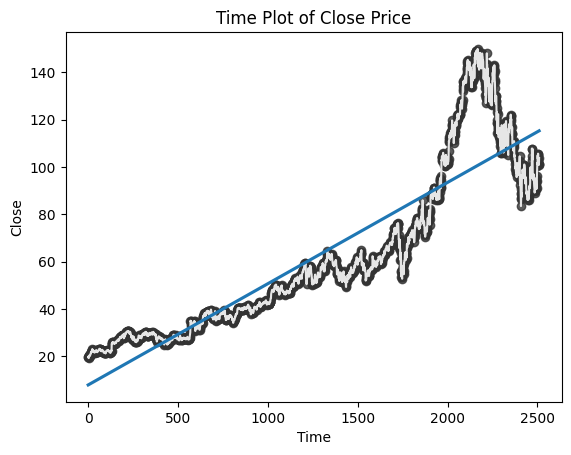

In [20]:
fig, ax = plt.subplots()
ax.plot('Time', 'Close', data=raw_df, color='0.9')
ax = sns.regplot(x='Time', y='Close', data=raw_df, ci=None, scatter_kws=dict(color='0.2'))
ax.set_title('Time Plot of Close Price');

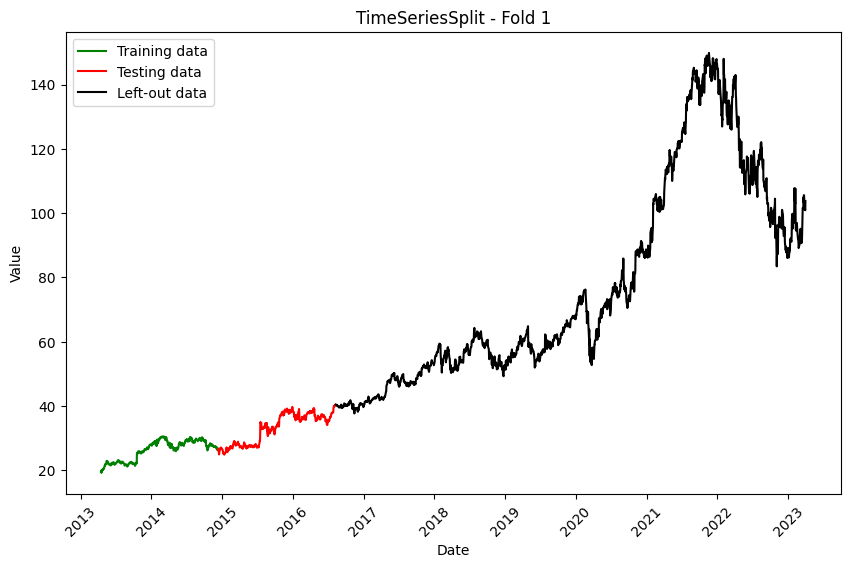

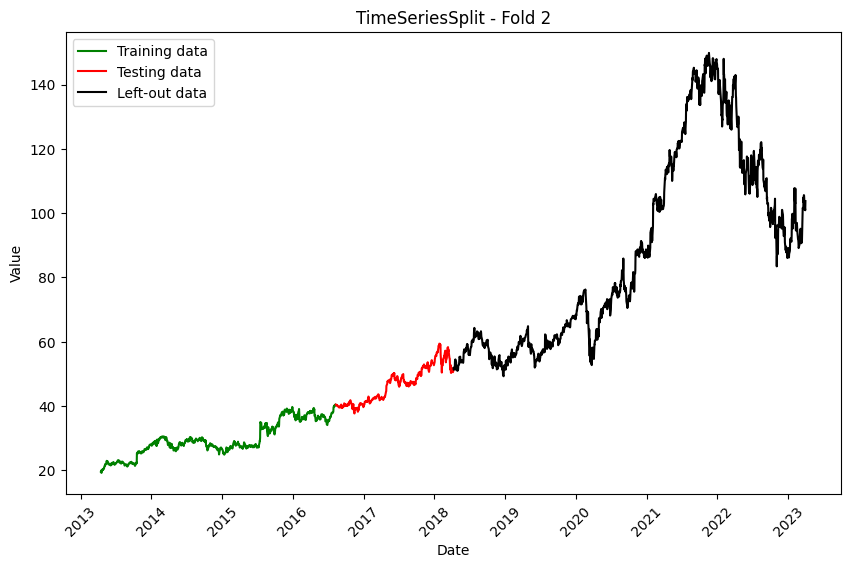

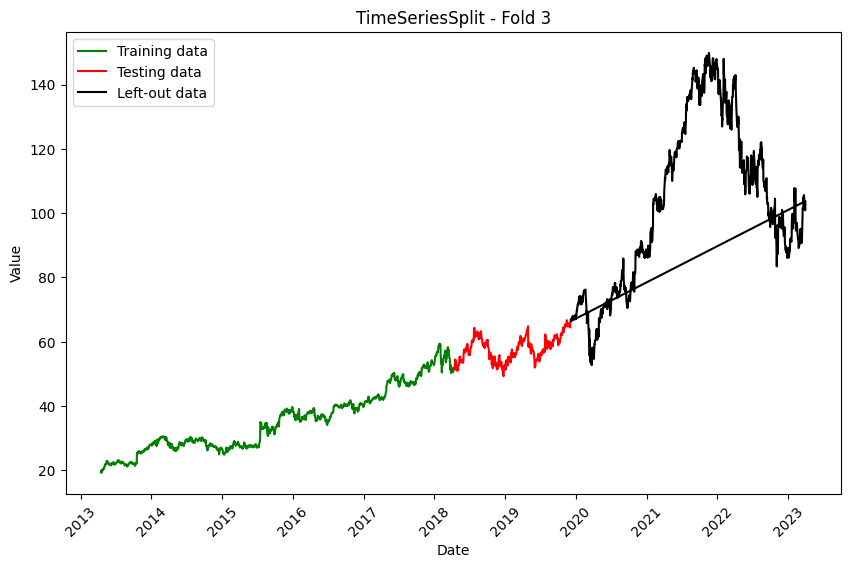

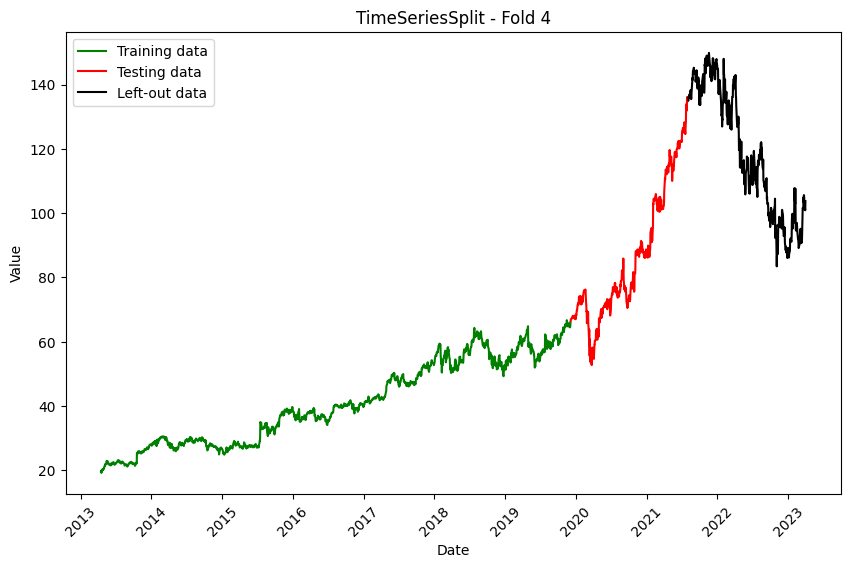

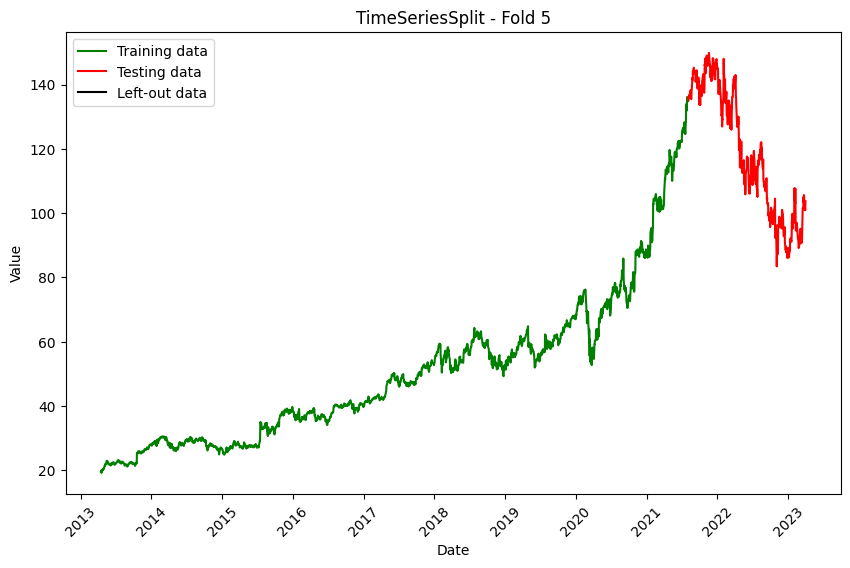

In [21]:

from sklearn.model_selection import TimeSeriesSplit

# Create X and y variables
X = raw_df.drop(['Close'], axis=1).values
y = raw_df['Close'].values
dates = raw_df.index.values

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Loop through each split and train/test the model
fold = 1
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    dates_train, dates_test = dates[train_index], dates[test_index]

    # Get the indices of the left-out data
    left_out_index = list(set(range(len(y))) - set(train_index) - set(test_index))
    dates_left = dates[left_out_index]

    # Plotting
    plt.figure(figsize=(10, 6))  # Set the figure size

    # Plot training data in green
    plt.plot(dates_train, y_train, color='green', label='Training data')

    # Plot testing data in red
    plt.plot(dates_test, y_test, color='red', label='Testing data')

    # Plot left-out data in black
    plt.plot(dates_left, y[left_out_index], color='black', label='Left-out data')

    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'TimeSeriesSplit - Fold {fold}')

    # Add legend
    plt.legend()

    # Rotate x-axis tick labels for better readability
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()

    # Increment fold number
    fold += 1


X_train(420, 4)
X_test(418, 4)
y_train(420,)
y_test(418,)
X_train(838, 4)
X_test(418, 4)
y_train(838,)
y_test(418,)
X_train(1256, 4)
X_test(418, 4)
y_train(1256,)
y_test(418,)
X_train(1674, 4)
X_test(418, 4)
y_train(1674,)
y_test(418,)
X_train(2092, 4)
X_test(418, 4)
y_train(2092,)
y_test(418,)
Training scores: [0.016538893595685483, 0.02498517712541328, 0.033293133874477486, 0.045660755833018644, 0.09993338293269244]
Test scores: [0.03382732763070804, 0.050018340364618996, 0.08306253774198936, 0.32122378460254275, 0.7842746223392542]


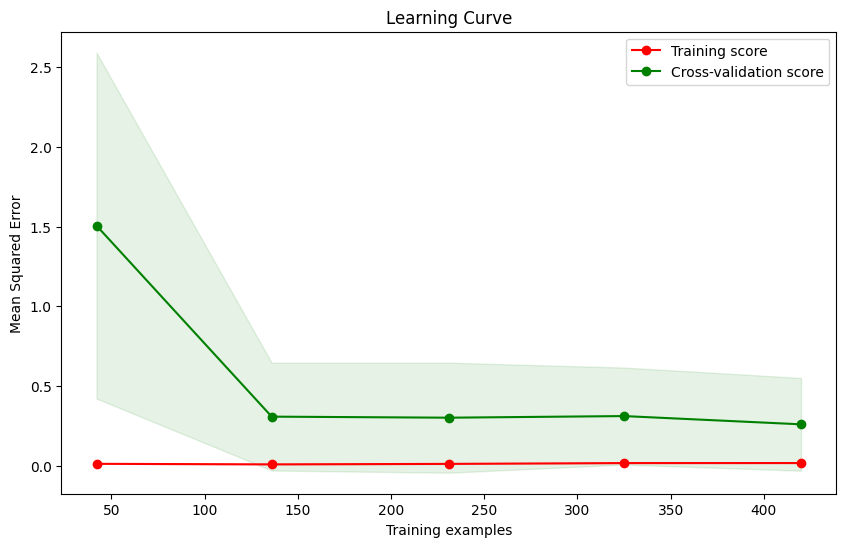

0.9998206104403017
0.9979987603367562


In [24]:
#LR Model with nonstationary data

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# Create X and y variables
X=raw_df.drop(['Close'], axis=1).values
y=raw_df['Close'].values
dates = raw_df.index.values

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Definelinear regression model
nonsta_reg = LinearRegression()

# Create empty lists to store the scores for each fold
train_scores = []
test_scores = []

# Loop through each split and train/test the model
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    dates_train, dates_test = dates[train_index], dates[test_index]
    print('X_train'+ str(X_train.shape))
    print('X_test'+ str(X_test.shape))
    print('y_train'+ str(y_train.shape))
    print('y_test'+ str(y_test.shape))

    # Fit the linear regression model
    nonsta_reg.fit(X_train, y_train)

    # Predict on training and test sets
    y_train_pred = nonsta_reg.predict(X_train)
    y_test_pred = nonsta_reg.predict(X_test)

    # Calculate mean squared error
    train_score = mean_squared_error(y_train, y_train_pred)
    test_score = mean_squared_error(y_test, y_test_pred)

    # Append scores to the lists
    train_scores.append(train_score)
    test_scores.append(test_score)
# Print the scores
print("Training scores:", train_scores[:])
print("Test scores:", test_scores[:])

# Set the parameters for learning_curve
train_sizes = np.linspace(0.1, 1.0, 5)
scoring = 'neg_mean_squared_error'  # Choose an appropriate scoring metric

# Calculate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=nonsta_reg,
    X=X,
    y=y,
    train_sizes=train_sizes,
    cv=tscv,
    scoring=scoring,
    n_jobs=1  # Set the number of jobs to run in parallel, adjust as needed
)

#Calculate mean and standard deviation of scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r"
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g"
)
plt.plot(
    train_sizes,
    train_scores_mean,
    'o-', color="r",
    label="Training score"
)
plt.plot(
    train_sizes,
    test_scores_mean,
    'o-', color="g",
    label="Cross-validation score"
)
plt.xlabel("Training examples")
plt.ylabel("Mean Squared Error")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()
mean_squared_error(y_train, y_train_pred)
print(nonsta_reg.score(X_train,y_train))
print(nonsta_reg.score(X_test,y_test))

In [25]:
comparison_table = pd.DataFrame({'Date':dates_test,'Actual_Value': y_test, 'Predicted_Value': y_test_pred})
comparison_table

,Date,Actual_Value,Predicted_Value
0,2021-08-04,135.13,135.020312
1,2021-08-05,136.25,135.650480
2,2021-08-06,135.74,135.831718
3,2021-08-09,136.91,136.517581
4,2021-08-10,136.81,137.014776
...,...,...,...
413,2023-03-27,102.46,102.691749
414,2023-03-28,101.03,100.404515
415,2023-03-29,101.39,101.237502
416,2023-03-30,100.89,100.290239


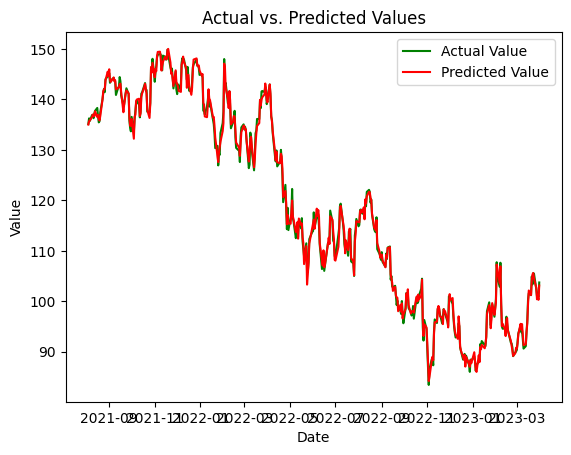

In [26]:
fig, ax = plt.subplots()

# Plot Actual Value in green
ax.plot(comparison_table['Date'], comparison_table['Actual_Value'], color='green', label='Actual Value')

# Plot Predicted Value in red
ax.plot(comparison_table['Date'], comparison_table['Predicted_Value'], color='red', label='Predicted Value')

# Add a legend
ax.legend()

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Actual vs. Predicted Values')

plt.show()

X_train(419, 4)
X_test(418, 4)
y_train(419,)
y_test(418,)
X_train(837, 4)
X_test(418, 4)
y_train(837,)
y_test(418,)
X_train(1255, 4)
X_test(418, 4)
y_train(1255,)
y_test(418,)
X_train(1673, 4)
X_test(418, 4)
y_train(1673,)
y_test(418,)
X_train(2091, 4)
X_test(418, 4)
y_train(2091,)
y_test(418,)
Training scores: [0.0003109176773148918, 0.00040624721422520516, 0.0004242748089063071, 0.0005010468921421661, 0.0009268668878324036]
Test scores: [0.0005096155241241412, 0.0004648569908484553, 0.0007332201176663534, 0.002659914376507442, 0.0030710299286032497]


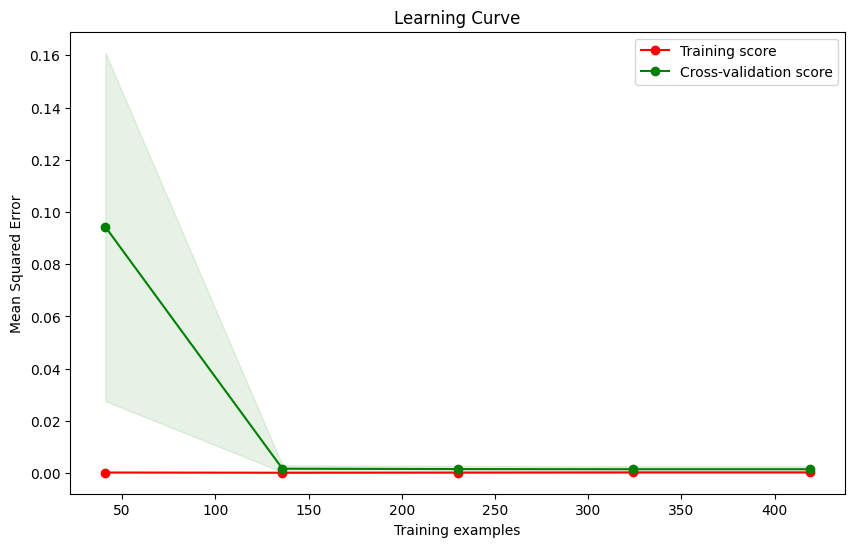

0.7316487470230054
0.7787192564016208


In [27]:
#LR Model with stationary data

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# Create X and y variables
X_stat=stat_df.drop(['Close_log'], axis=1).values
y_stat=stat_df['Close_log'].values

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Definelinear regression model
sta_reg = LinearRegression()

# Create empty lists to store the scores for each fold
train_scores = []
test_scores = []

# Loop through each split and train/test the model
for train_index, test_index in tscv.split(X_stat):
    X_stat_train, X_stat_test = X_stat[train_index], X_stat[test_index]
    y_stat_train, y_stat_test = y_stat[train_index], y_stat[test_index]
    print('X_train'+ str(X_stat_train.shape))
    print('X_test'+ str(X_stat_test.shape))
    print('y_train'+ str(y_stat_train.shape))
    print('y_test'+ str(y_stat_test.shape))

    # Fit the linear regression model
    sta_reg.fit(X_stat_train, y_stat_train)

    # Predict on training and test sets
    y_stat_train_pred = sta_reg.predict(X_stat_train)
    y_stat_test_pred = sta_reg.predict(X_stat_test)

    # Calculate mean squared error
    train_score = mean_squared_error(y_stat_train, y_stat_train_pred)
    test_score = mean_squared_error(y_stat_test, y_stat_test_pred)

    # Append scores to the lists
    train_scores.append(train_score)
    test_scores.append(test_score)
# Print the scores
print("Training scores:", train_scores[:])
print("Test scores:", test_scores[:])

# Set the parameters for learning_curve
train_sizes = np.linspace(0.1, 1.0, 5)
scoring = 'neg_mean_squared_error'  # Choose an appropriate scoring metric

# Calculate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=sta_reg,
    X=X_stat,
    y=y_stat,
    train_sizes=train_sizes,
    cv=tscv,
    scoring=scoring,
    n_jobs=1  # Set the number of jobs to run in parallel, adjust as needed
)

#Calculate mean and standard deviation of scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r"
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g"
)
plt.plot(
    train_sizes,
    train_scores_mean,
    'o-', color="r",
    label="Training score"
)
plt.plot(
    train_sizes,
    test_scores_mean,
    'o-', color="g",
    label="Cross-validation score"
)
plt.xlabel("Training examples")
plt.ylabel("Mean Squared Error")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()
mean_squared_error(y_stat_train, y_stat_train_pred)
print(sta_reg.score(X_stat_train,y_stat_train))
print(sta_reg.score(X_stat_test,y_stat_test))

In [41]:
restore_point = y[test_index[0] - 1]

In [42]:
comparison_table_2 = pd.DataFrame({'Actual_Value': y_stat_test, 'Predicted_Value': y_stat_test_pred})
comparison_table_2

#Plot giúp t cái graph vớii

,Actual_Value,Predicted_Value
0,-0.021486,0.030736
1,0.048075,0.025912
2,-0.021866,0.007108
3,0.050104,0.029589
4,-0.004274,0.016656
...,...,...
413,-0.146145,-0.084810
414,-0.070885,-0.099984
415,0.017892,0.041237
416,-0.024859,-0.039331


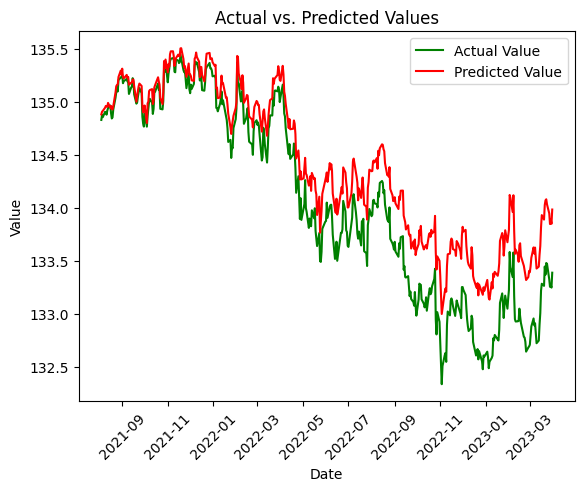

In [50]:
fig, ax = plt.subplots()

# Plot Actual Value in green
ax.plot(comparison_table['Date'], revert_to_non_stationary(restore_point, comparison_table_2['Actual_Value'])[1:], color='green', label='Actual Value')

# Plot Predicted Value in red
ax.plot(comparison_table['Date'], revert_to_non_stationary(restore_point, comparison_table_2['Predicted_Value'])[1:], color='red', label='Predicted Value')

# Add a legend
ax.legend()

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Actual vs. Predicted Values')

plt.xticks(rotation=45)

plt.show()

### Cải tiến model

Training scores: [0.016538933654541343, 0.024985184173557436, 0.033293136035160445, 0.0456607566195844, 0.09993338318281665]
Test scores: [0.03383074081638675, 0.050016372015695226, 0.08306479243645098, 0.32121984092558603, 0.784288633820686]


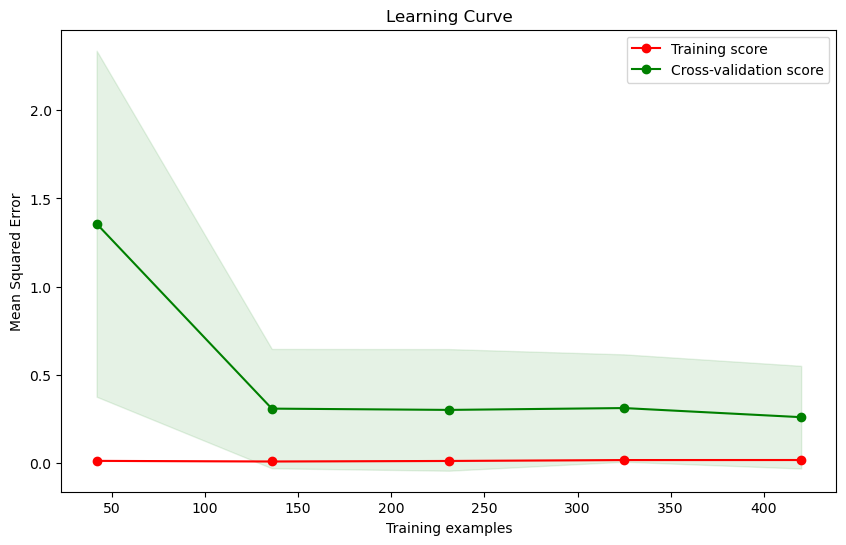

Training score: 0.9998206104398526
Testing score: 0.9979987245835499


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# Create X and y variables
X = raw_df.drop(['Close'], axis=1).values
y = raw_df['Close'].values

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Define Ridge regression model
reg = Ridge()

# Create parameter grid for GridSearchCV
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0],  # Regularization strength
}

# Perform GridSearchCV with TimeSeriesSplit
grid_search = GridSearchCV(reg, param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

# Get the best Ridge regression model with the best hyperparameters
best_reg = grid_search.best_estimator_

# Create empty lists to store the scores for each fold
train_scores = []
test_scores = []

# Loop through each split and train/test the model
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the Ridge regression model with the best hyperparameters
    best_reg.fit(X_train, y_train)

    # Predict on training and test sets
    y_train_pred = best_reg.predict(X_train)
    y_test_pred = best_reg.predict(X_test)

    # Calculate mean squared error
    train_score = mean_squared_error(y_train, y_train_pred)
    test_score = mean_squared_error(y_test, y_test_pred)

    # Append scores to the lists
    train_scores.append(train_score)
    test_scores.append(test_score)

# Print the scores
print("Training scores:", train_scores)
print("Test scores:", test_scores)

# Set the parameters for learning_curve
train_sizes = np.linspace(0.1, 1.0, 5)
scoring = 'neg_mean_squared_error'  # Choose an appropriate scoring metric

# Calculate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_reg,
    X=X,
    y=y,
    train_sizes=train_sizes,
    cv=tscv,
    scoring=scoring,
    n_jobs=-1  # Use all available CPU cores for parallel computation
)

# Calculate mean and standard deviation of scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r"
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g"
)
plt.plot(
    train_sizes,
    train_scores_mean,
    'o-', color="r",
    label="Training score"
)
plt.plot(
    train_sizes,
    test_scores_mean,
    'o-', color="g",
    label="Cross-validation score"
)
plt.xlabel("Training examples")
plt.ylabel("Mean Squared Error")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

# Calculate scores on the training and testing data separately
train_score = best_reg.score(X_train, y_train)
test_score = best_reg.score(X_test, y_test)

print("Training score:", train_score)
print("Testing score:", test_score)


In [ ]:
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 0.01}
-0.22015430865066027
